The point here is to process and analyse the scATACseq data coming from the brain. 
The data originally come from Cusanovich et al. 2018. and the matrix we are using is build on peaks


### Loading import libraries

In [27]:
import episcanpy.api as epi
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

# Extract the Brain data from the whole Cusanovcih atlas

In [2]:
result_file = 'Brain_Cusanovich.h5ad'
DATADIR = './data/'

In [3]:
adata = ad.read(DATADIR+'All_tissues_Cusanovich_peakmatrix.h5ad')
adata

AnnData object with n_obs × n_vars = 97899 × 436206 
    obs: 'batch', 'cell_names', 'tissue', 'sample'

In [4]:
# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

In [5]:
# the current matrix containt the following tissues. We are only interested in the brain
set(adata.obs['tissue'])

{'BoneMarrow',
 'Cerebellum',
 'HeartA',
 'Kidney',
 'LargeIntestineA',
 'LargeIntestineB',
 'Liver',
 'Lung1',
 'Lung2',
 'PreFrontalCortex',
 'SmallIntestine',
 'Spleen',
 'Testes',
 'Thymus',
 'WholeBrainA'}

In [6]:
# Filter the adata to only keep brain tissue
brain_tissue = ['WholeBrainA', 'PreFrontalCortex', 'Cerebellum']
annot = []
for tissue in adata.obs['tissue']:
    if tissue in brain_tissue:
        annot.append('keep')
    else:
        annot.append('discard')
adata.obs['keep_brain'] = annot

adata = adata[adata.obs['keep_brain']=='keep',:].copy()
del adata.obs['keep_brain']

In [14]:
adata

AnnData object with n_obs × n_vars = 18710 × 436206 
    obs: 'batch', 'cell_names', 'tissue', 'sample', 'cell', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label'

### Cell labels, batch information and other metadata

In [8]:
# Load annotation cell types
input_metadata = 'Cusanovich_metadata.txt'
epi.pp.load_metadata(adata,
                     metadata_file=DATADIR+input_metadata,
                     separator='\t')
# format cell label to remove '\n'
adata.obs['cell_label'] = [n.rstrip('\n') for n in adata.obs['cell_label\n']]
del adata.obs['cell_label\n']

In [11]:
adata

AnnData object with n_obs × n_vars = 18710 × 436206 
    obs: 'batch', 'cell_names', 'tissue', 'sample', 'cell', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label'

### peak - promoter intersection annotations

In [24]:
# Load peak annotations
peak_promoter_intersection_file = 'peak_promoter_intersections.txt'

peak_promoter = pd.read_csv(DATADIR+peak_promoter_intersection_file, header=0, sep='\t')
peak_promoter = peak_promoter.set_index('peak_id')
#peak_promoter

In [15]:
## add annotation to the adata object
for annotation in ['ensembl_id','gene_short_name','ensembl_transcript_id','biotype','strand']:
    annot = []
    for name in adata.var_names.tolist():
        if name in peak_promoter.index.tolist():
            annot.append(peak_promoter.loc[name, annotation])
        else:
            annot.append('NA')
    adata.var[annotation] = annot

### save the raw matrix layer

In [17]:
adata.raw = adata

### save the raw Cusanovich brain file

In [18]:
#adata.write(DATADIR+result_file)

... storing 'tissue' as categorical
... storing 'cell' as categorical
... storing 'tissue.replicate' as categorical
... storing 'cluster' as categorical
... storing 'subset_cluster' as categorical
... storing 'tsne_1' as categorical
... storing 'tsne_2' as categorical
... storing 'subset_tsne1' as categorical
... storing 'subset_tsne2' as categorical
... storing 'id' as categorical
... storing 'cell_label' as categorical
... storing 'ensembl_id' as categorical
... storing 'gene_short_name' as categorical
... storing 'ensembl_transcript_id' as categorical
... storing 'biotype' as categorical
... storing 'strand' as categorical
... storing 'ensembl_id' as categorical
... storing 'gene_short_name' as categorical
... storing 'ensembl_transcript_id' as categorical
... storing 'biotype' as categorical
... storing 'strand' as categorical


# Filtering and Quality controls

In [28]:
# Load the adata for data processing
input_file = 'Brain_Cusanovich.h5ad'
result_file = 'Brain_Cusanovich_processed.h5ad'

In [29]:
adata = ad.read(DATADIR+input_file)
adata

AnnData object with n_obs × n_vars = 18710 × 436206 
    obs: 'batch', 'cell_names', 'tissue', 'sample', 'cell', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label'
    var: 'ensembl_id', 'gene_short_name', 'ensembl_transcript_id', 'biotype', 'strand'

In [30]:
# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

#### filtering empty cells and/or empty features

In [31]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)

In [32]:
adata

AnnData object with n_obs × n_vars = 18710 × 436204 
    obs: 'batch', 'cell_names', 'tissue', 'sample', 'cell', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'nb_features'
    var: 'ensembl_id', 'gene_short_name', 'ensembl_transcript_id', 'biotype', 'strand', 'n_cells'

#### Checking if the matrix is binary

In [33]:
# checking if the matrix is binary
np.max(adata.X) # matrix is not binary

26.0

In [34]:
# binarize the matrix
epi.pp.binarize(adata)

In [35]:
# checking if the matrix is binary
np.max(adata.X) # matrix is binary

1.0

### Looking at the cell coverage 

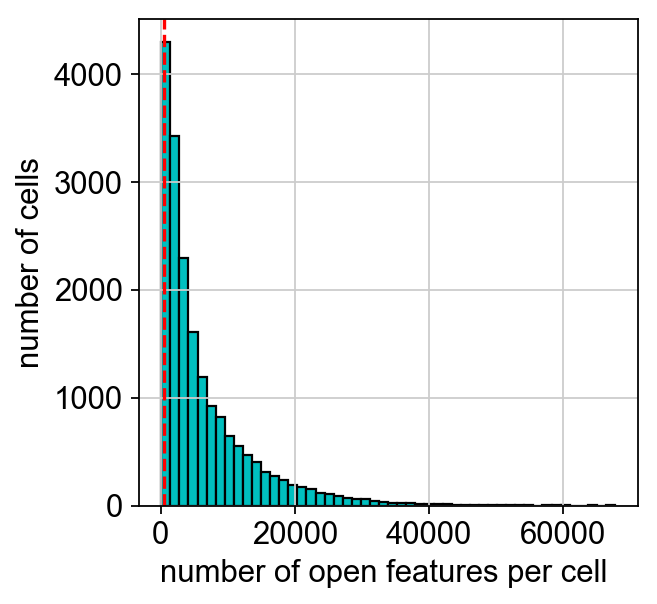

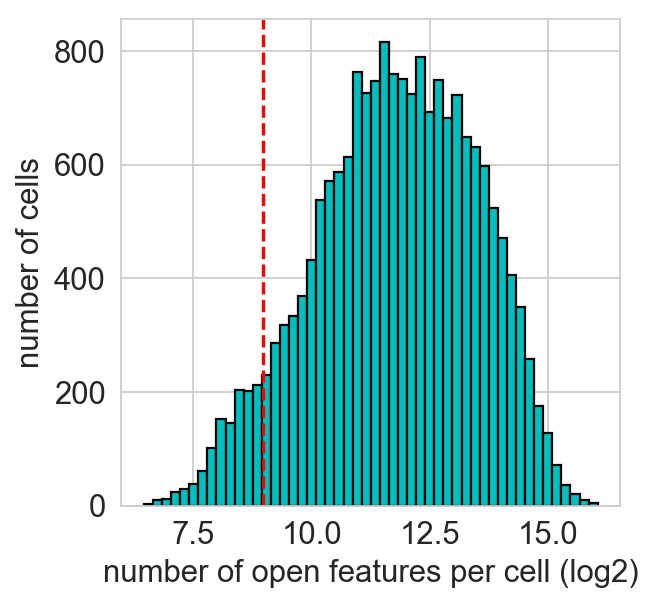

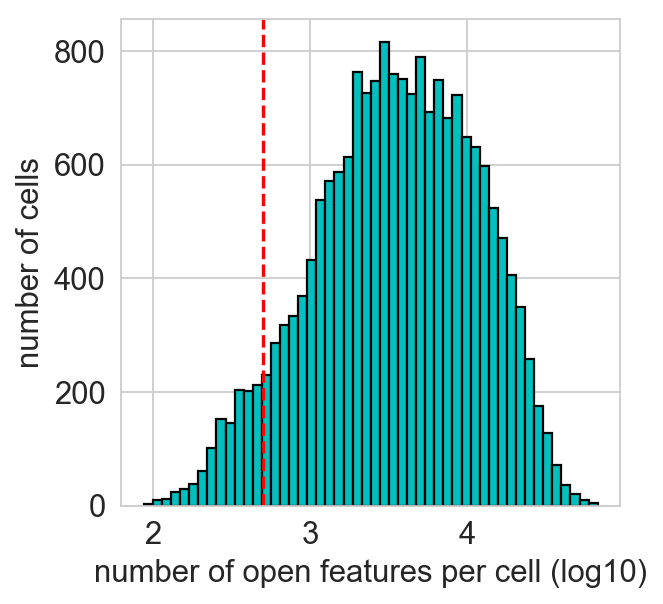

In [36]:
epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=500, save='coverage_cells.png')
epi.pp.coverage_cells(adata, binary=True, log='log2', bins=50, 
               threshold=500, save='coverage_cells_log2.png')
epi.pp.coverage_cells(adata, binary=True, log='log10', bins=50, 
               threshold=500, save='coverage_cells_log10.png')

### Looking at the feature coverage

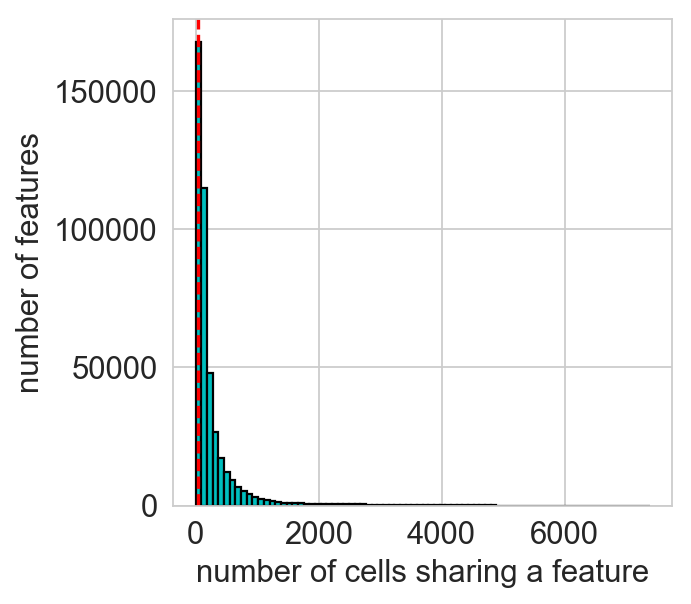

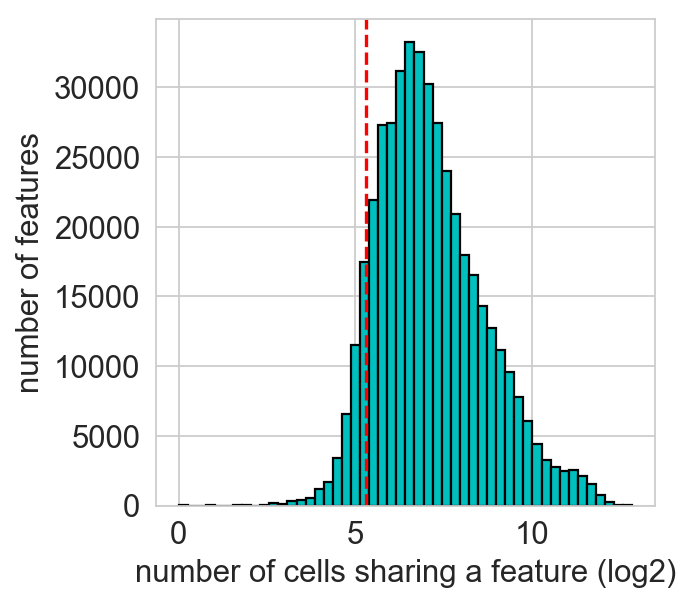

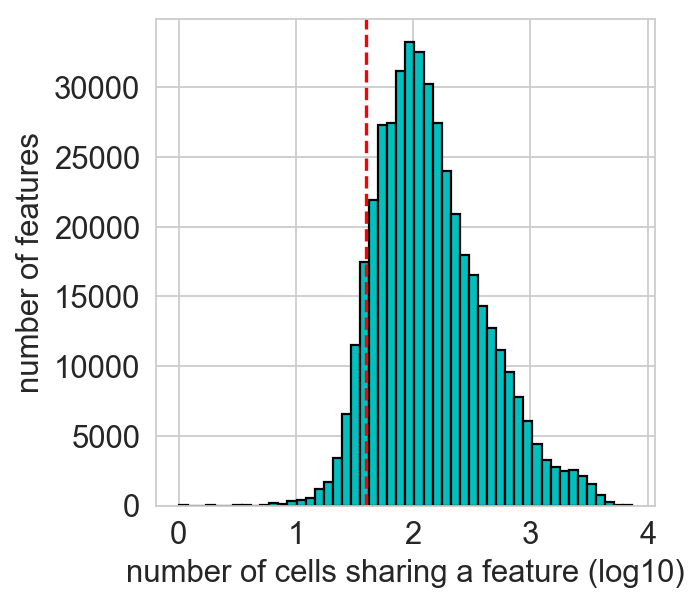

In [37]:
epi.pp.coverage_features(adata, binary=True, log=False,
                  bins=50, threshold=40,
                  save='coverage_features.png')
epi.pp.coverage_features(adata, binary=True, log='log2',
                  bins=50, threshold=40,
                  save='coverage_features_log2.png')
epi.pp.coverage_features(adata, binary=True, log='log10',
                  bins=50, threshold=40,
                  save='coverage_features_log10.png')

#### Distribution of feature coverage

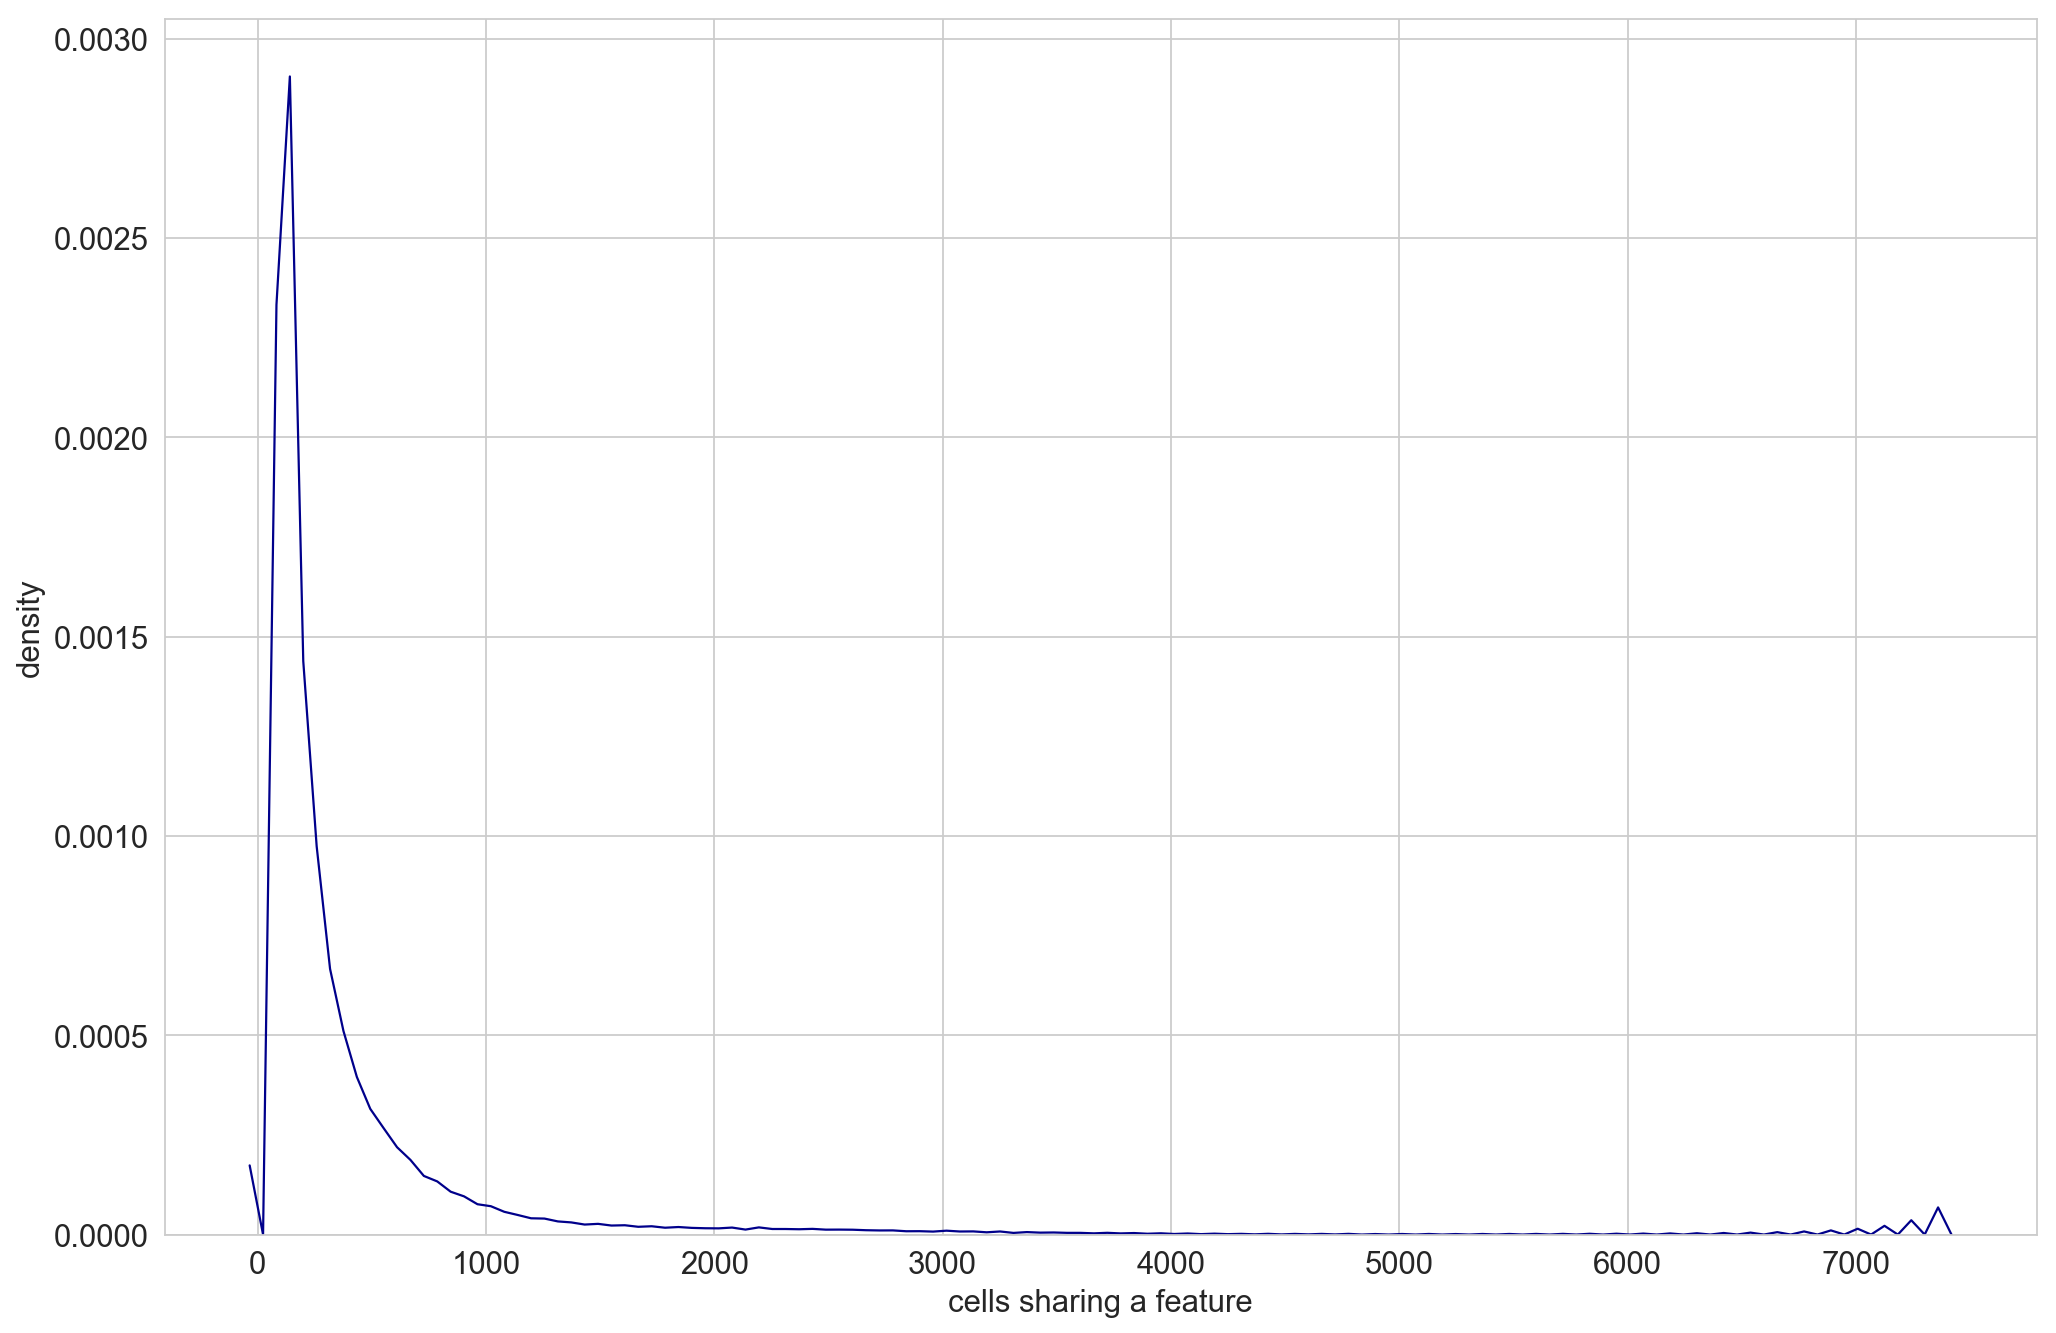

In [38]:
epi.pp.density_features(adata, save='density_cells_sharing_a_feature.png')

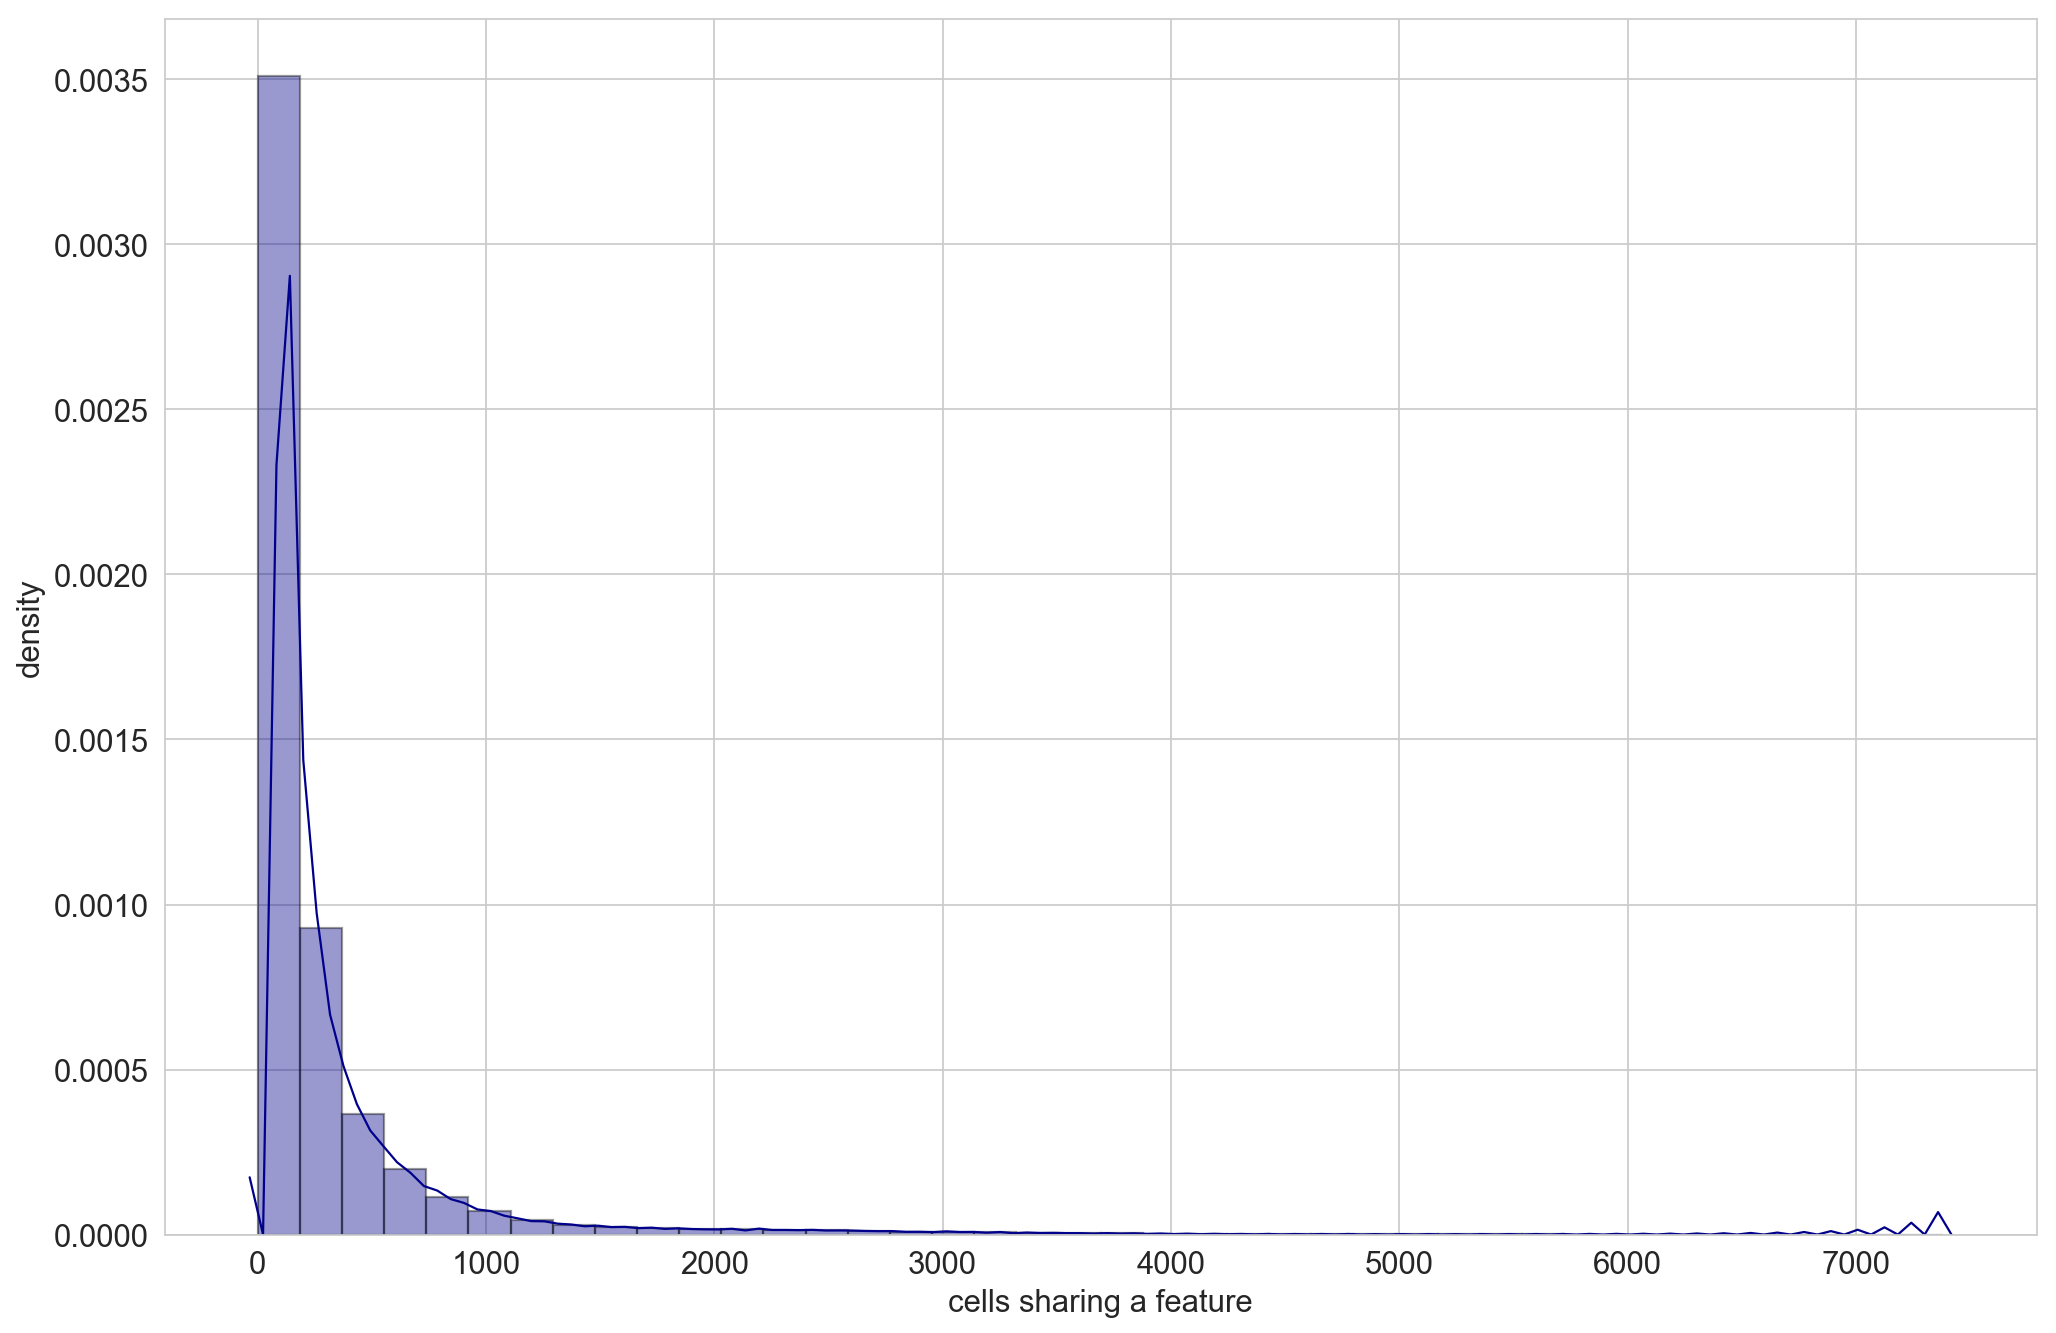

In [39]:
epi.pp.density_features(adata, hist=True, bins=40, save='density_cells_sharing_a_feature_with_histogram.png')

### Removing low quality cells and features

In [40]:
adata

AnnData object with n_obs × n_vars = 18710 × 436204 
    obs: 'batch', 'cell_names', 'tissue', 'sample', 'cell', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'nb_features'
    var: 'ensembl_id', 'gene_short_name', 'ensembl_transcript_id', 'biotype', 'strand', 'n_cells', 'commonness'

In [41]:
# removing cells. with less than 500 features covered
epi.pp.filter_cells(adata, min_features=500)
adata

AnnData object with n_obs × n_vars = 17503 × 436204 
    obs: 'batch', 'cell_names', 'tissue', 'sample', 'cell', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'nb_features'
    var: 'ensembl_id', 'gene_short_name', 'ensembl_transcript_id', 'biotype', 'strand', 'n_cells', 'commonness'

In [42]:
# removing features covered in less than 40 cells
epi.pp.filter_features(adata, min_cells=40)
adata

AnnData object with n_obs × n_vars = 17503 × 399859 
    obs: 'batch', 'cell_names', 'tissue', 'sample', 'cell', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'nb_features'
    var: 'ensembl_id', 'gene_short_name', 'ensembl_transcript_id', 'biotype', 'strand', 'n_cells', 'commonness'

#### Looking at the cell and feature coverage post filtering

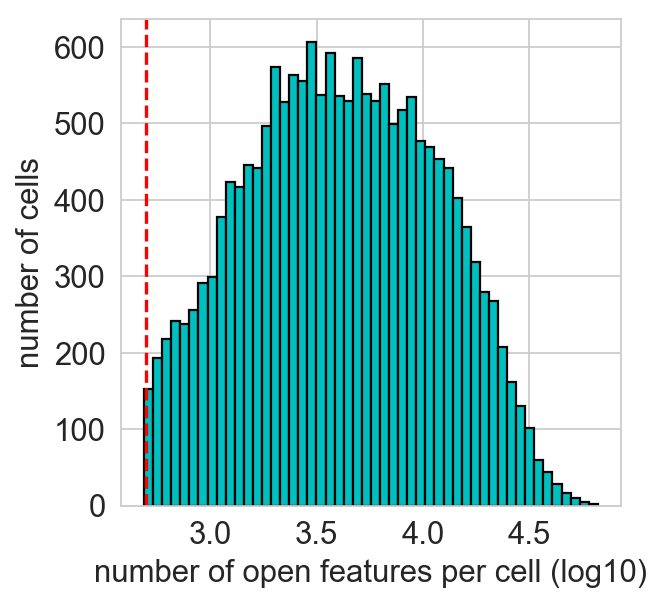

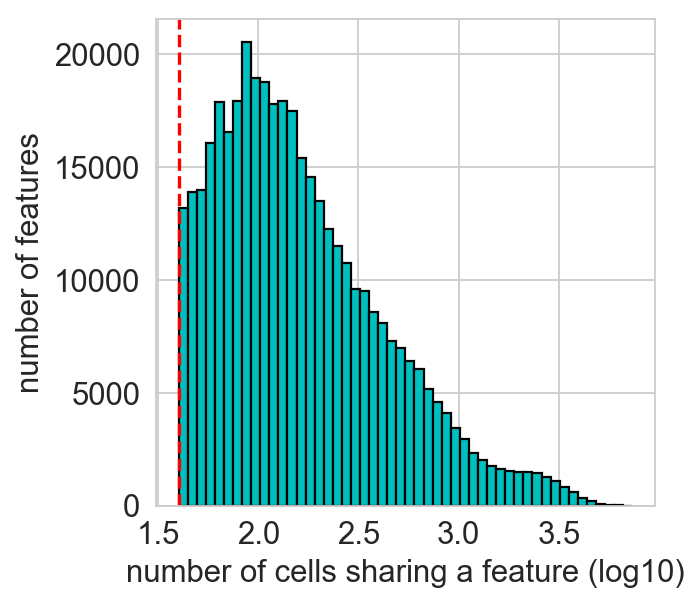

In [43]:
epi.pp.coverage_cells(adata, binary=True, log='log10', bins=50, threshold=500)
epi.pp.coverage_features(adata, binary=True, log='log10', bins=50, threshold=40)

### Identifying the most variable features

In [44]:
adata

AnnData object with n_obs × n_vars = 17503 × 399859 
    obs: 'batch', 'cell_names', 'tissue', 'sample', 'cell', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'nb_features'
    var: 'ensembl_id', 'gene_short_name', 'ensembl_transcript_id', 'biotype', 'strand', 'n_cells', 'commonness'

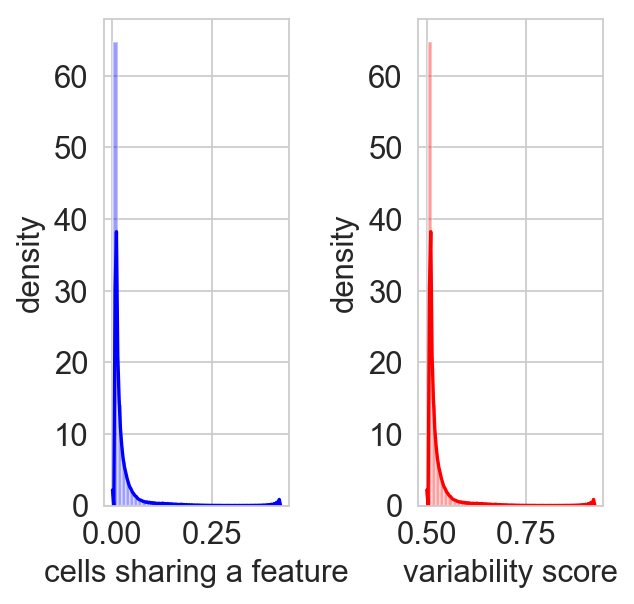

In [45]:
epi.pp.cal_var(adata)

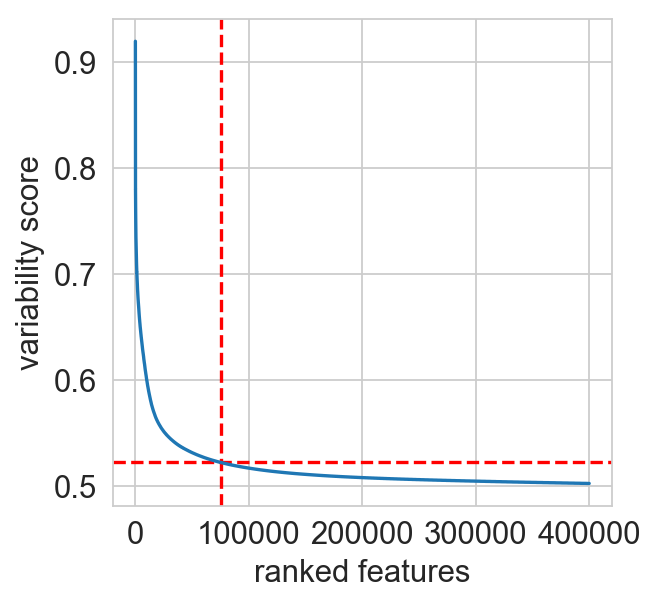

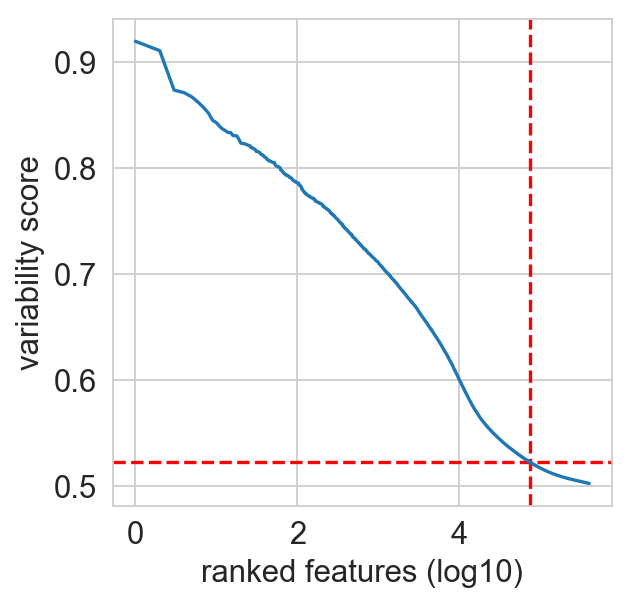

In [46]:
epi.pl.variability_features(adata,log=None,
                     min_score=0.523, nb_features=75000,
                     save='variability_features_plot_score0523_nb_feat75000.png')

epi.pl.variability_features(adata,log='log10',
                     min_score=0.523, nb_features=75000,
                     save='variability_features_plot_score0523_nb_feat75000_log10.png')

### Filtering the matrix to only retain the top 75000 most variable features

In [47]:
adata

AnnData object with n_obs × n_vars = 17503 × 399859 
    obs: 'batch', 'cell_names', 'tissue', 'sample', 'cell', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'nb_features'
    var: 'ensembl_id', 'gene_short_name', 'ensembl_transcript_id', 'biotype', 'strand', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [48]:
adata2 = epi.pp.select_var_feature(adata,
                            nb_features=75000,
                            show=False,
                            copy=True)

In [49]:
adata2

View of AnnData object with n_obs × n_vars = 17503 × 75067 
    obs: 'batch', 'cell_names', 'tissue', 'sample', 'cell', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'nb_features'
    var: 'ensembl_id', 'gene_short_name', 'ensembl_transcript_id', 'biotype', 'strand', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [50]:
adata2.write(DATADIR+result_file)
del adata2

# Principal Component Analysis

In [51]:
result_file = 'Brain_Cusanovich_processed.h5ad'
adata = ad.read(DATADIR+result_file)

In [52]:
adata

AnnData object with n_obs × n_vars = 17503 × 75067 
    obs: 'batch', 'cell_names', 'tissue', 'sample', 'cell', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'nb_features'
    var: 'ensembl_id', 'gene_short_name', 'ensembl_transcript_id', 'biotype', 'strand', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [53]:
epi.pp.pca(adata, n_comps=50, svd_solver='arpack')

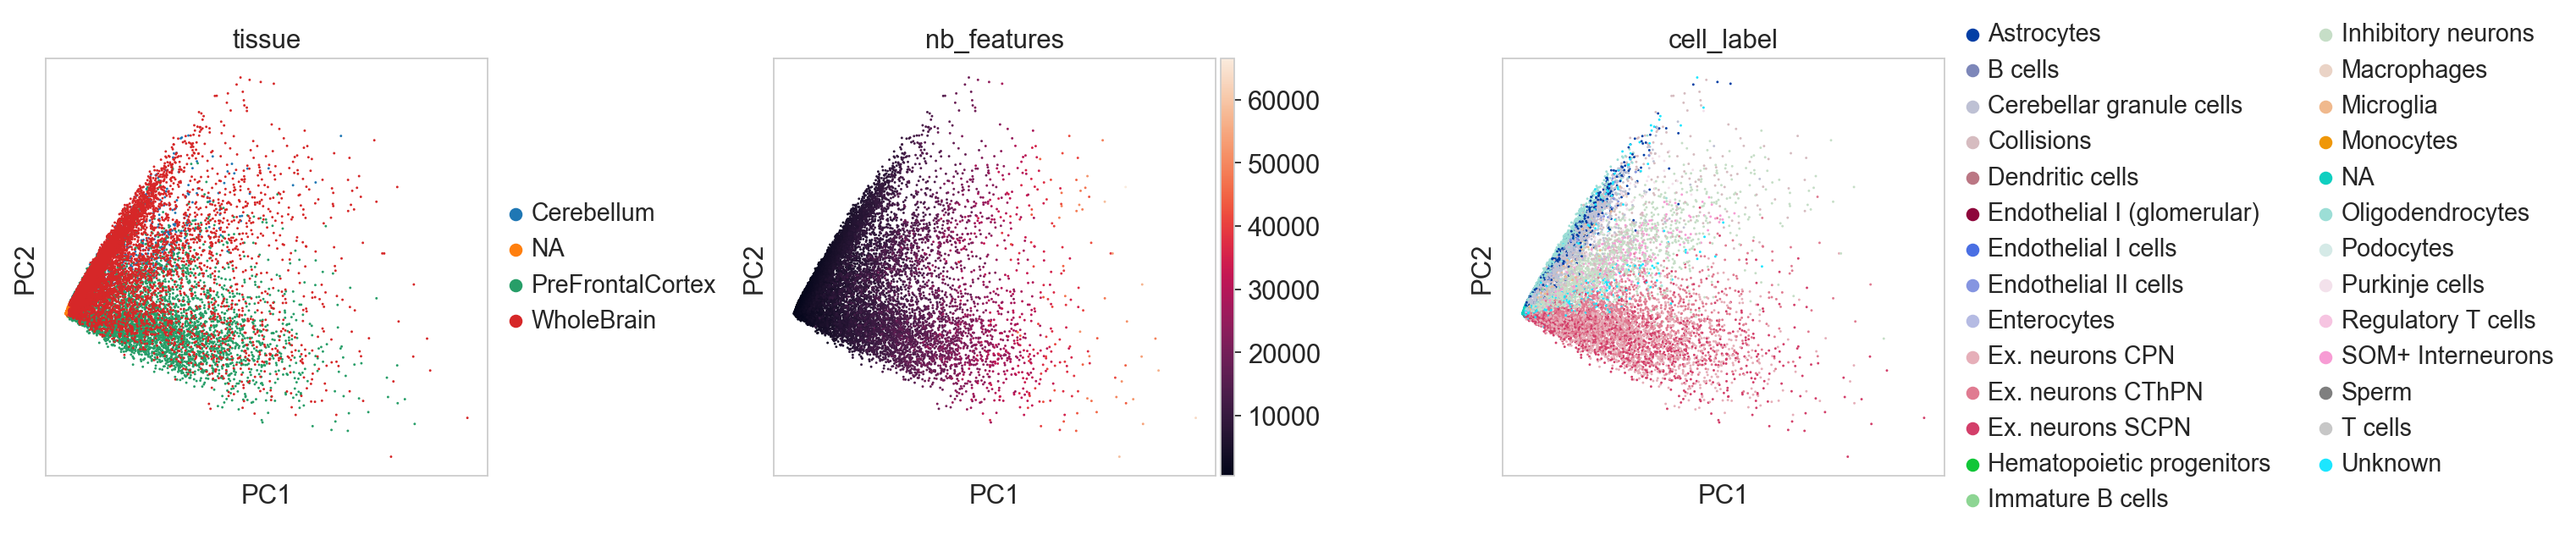

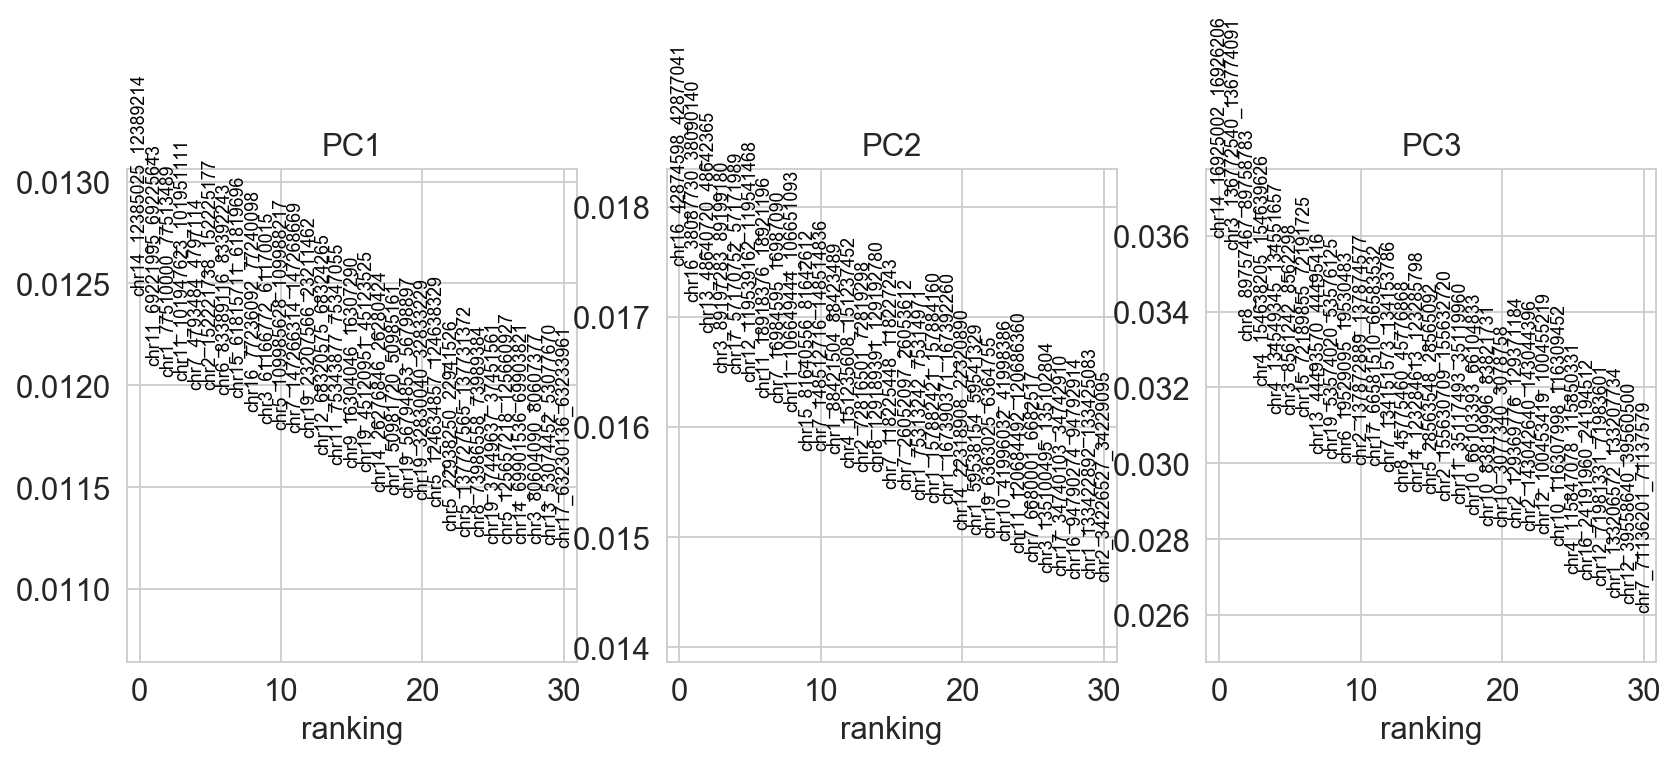

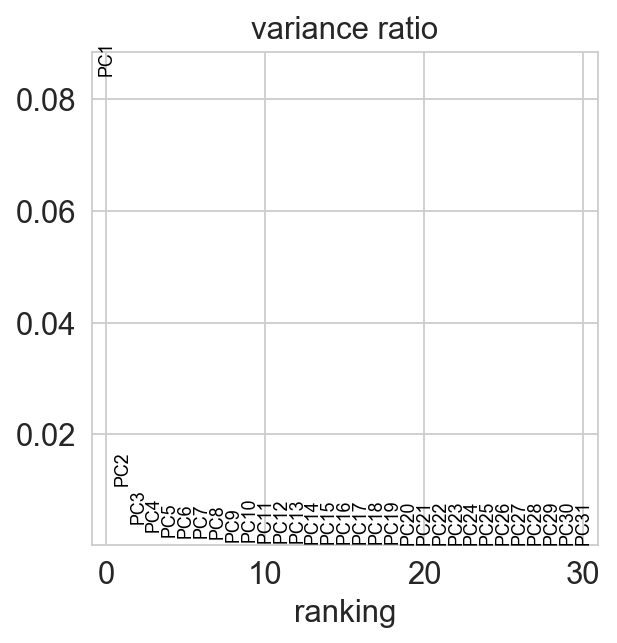

In [54]:
sc.pl.pca_overview(adata, color=['tissue', 'nb_features', 'cell_label'], wspace=0.5)

correlation: 0.9761376370321361
pval: 0.0


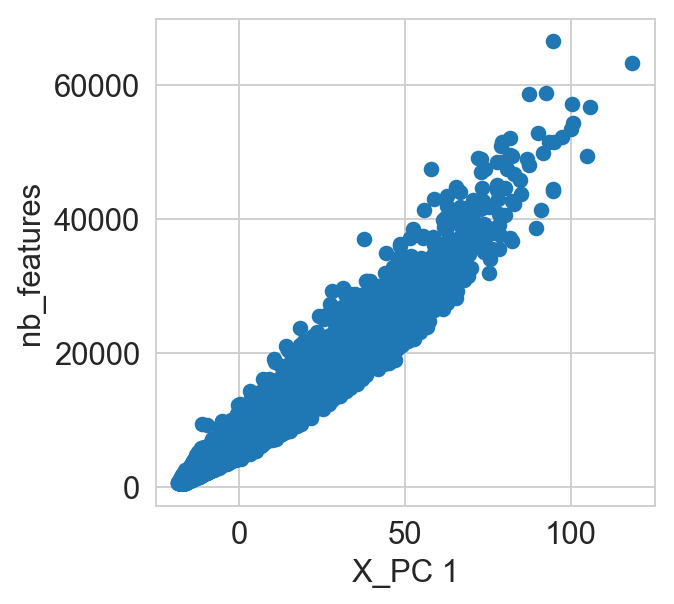

In [55]:
# check correlation between number of features and PC1
epi.pp.correlation_pc(adata, 'nb_features')

### Library size normalisation

In [56]:
adata

AnnData object with n_obs × n_vars = 17503 × 75067 
    obs: 'batch', 'cell_names', 'tissue', 'sample', 'cell', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'nb_features'
    var: 'ensembl_id', 'gene_short_name', 'ensembl_transcript_id', 'biotype', 'strand', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'pca', 'tissue_colors', 'cell_label_colors', 'correlation_pc'
    obsm: 'X_pca'
    varm: 'PCs'

In [57]:
epi.pp.normalize_total(adata)
epi.pp.log1p(adata)

# Principal Component Analysis

In [58]:
epi.pp.pca(adata, n_comps=100, svd_solver='arpack')

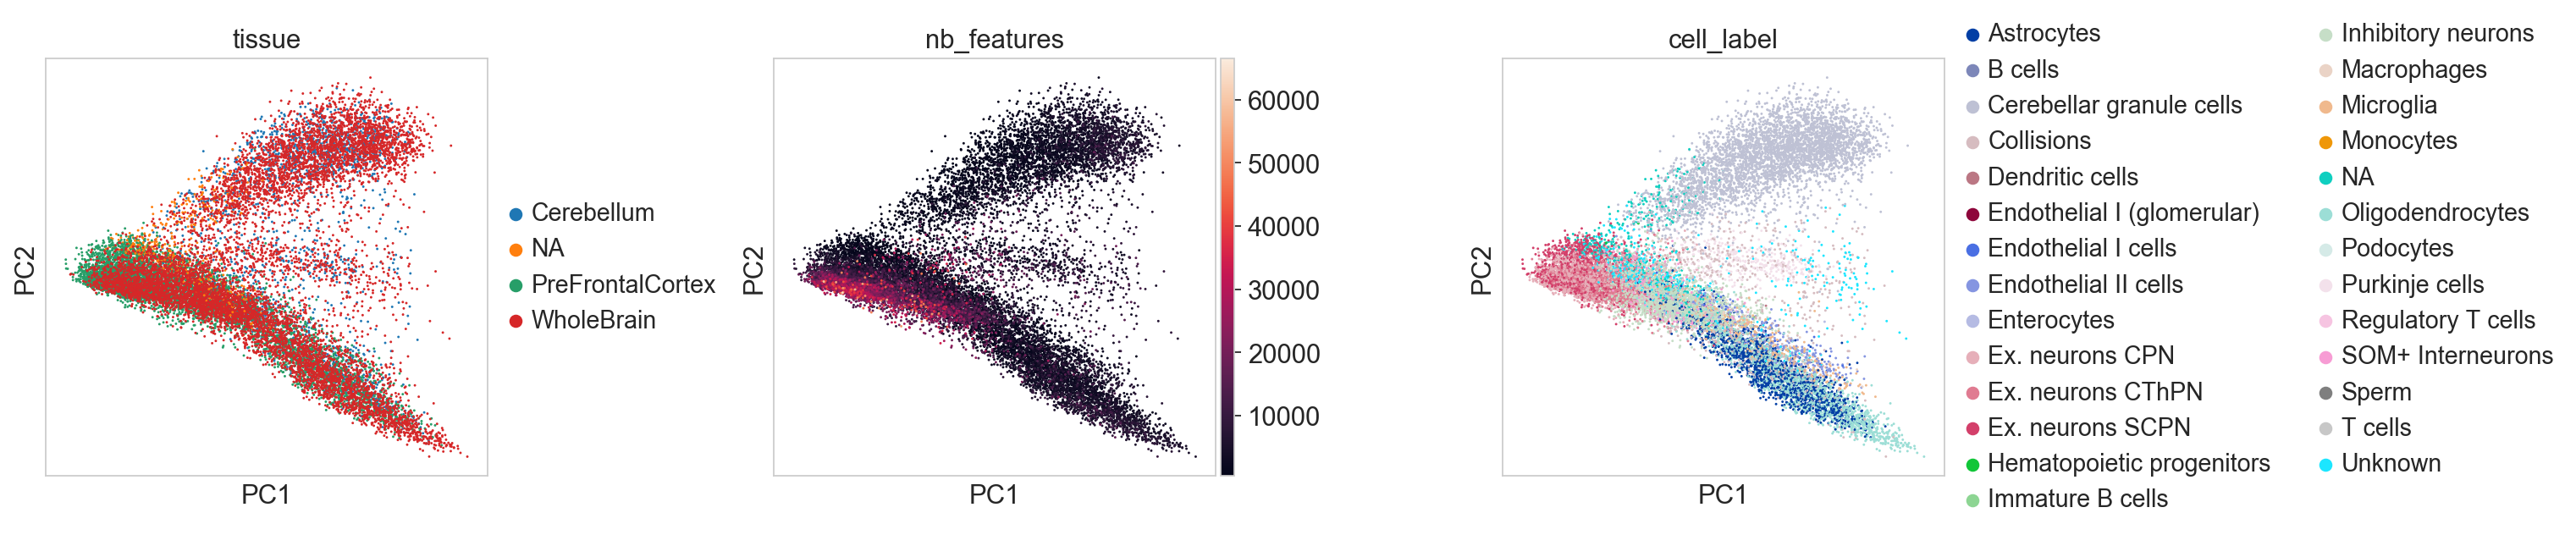

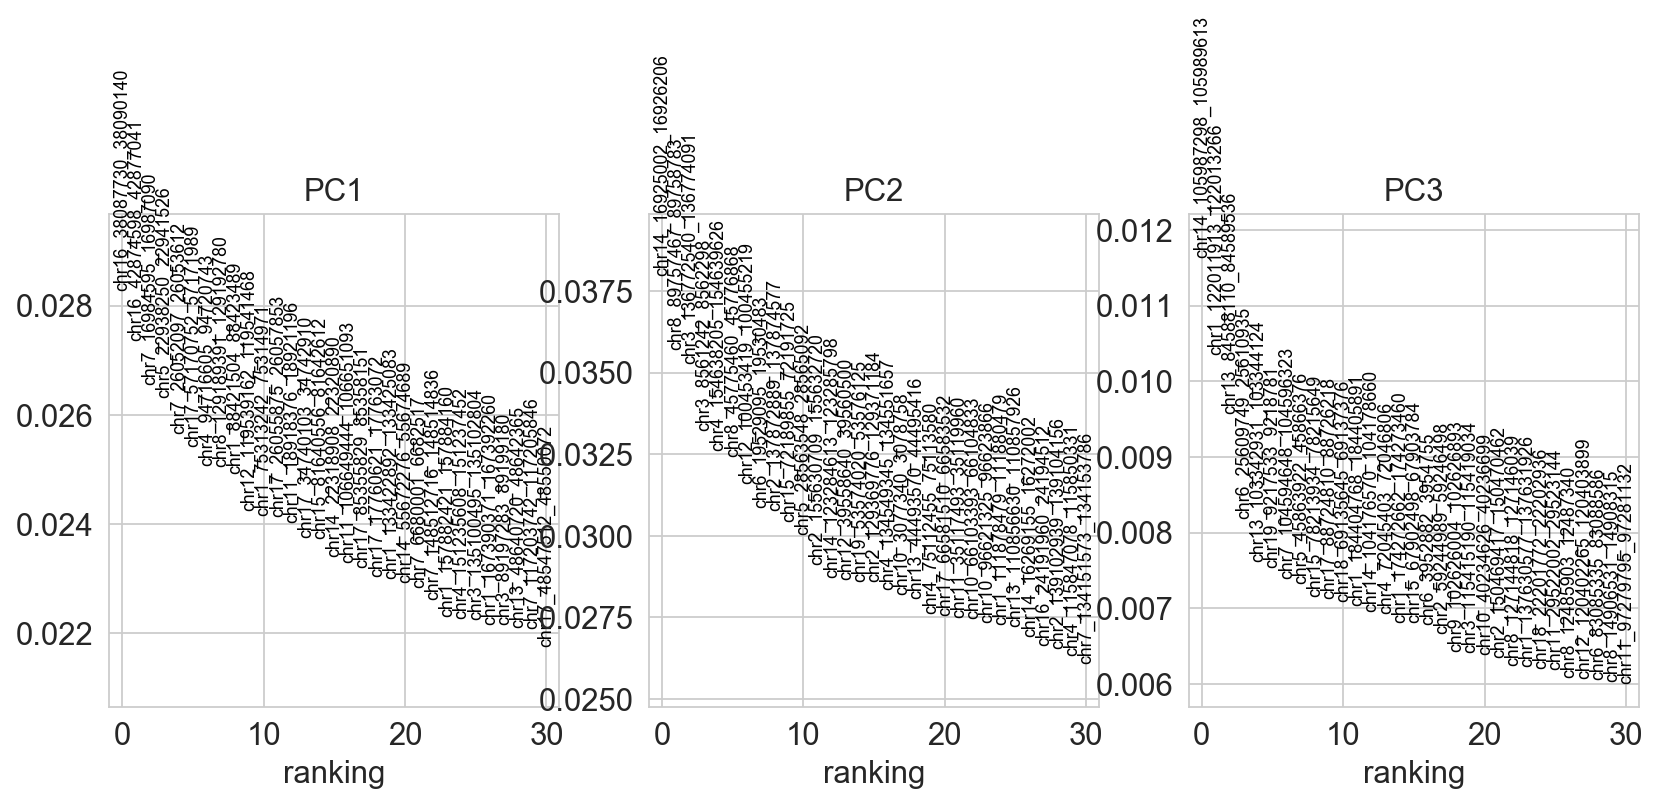

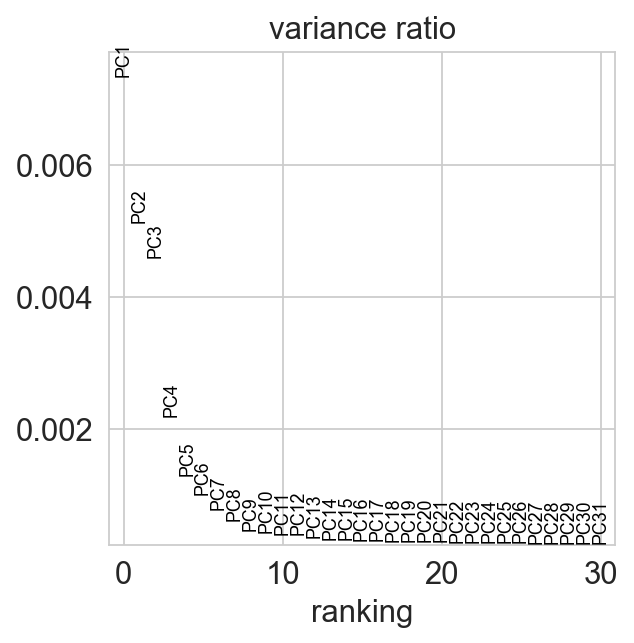

In [59]:
epi.pl.pca_overview(adata)
sc.pl.pca(adata, color=['tissue', 'nb_features', 'cell_label'], wspace=0.5)

In [61]:
adata

AnnData object with n_obs × n_vars = 17503 × 75067 
    obs: 'batch', 'cell_names', 'tissue', 'sample', 'cell', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'nb_features'
    var: 'ensembl_id', 'gene_short_name', 'ensembl_transcript_id', 'biotype', 'strand', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'pca', 'tissue_colors', 'cell_label_colors', 'correlation_pc'
    obsm: 'X_pca'
    varm: 'PCs'

correlation: -0.38426294777118386
pval: 0.0


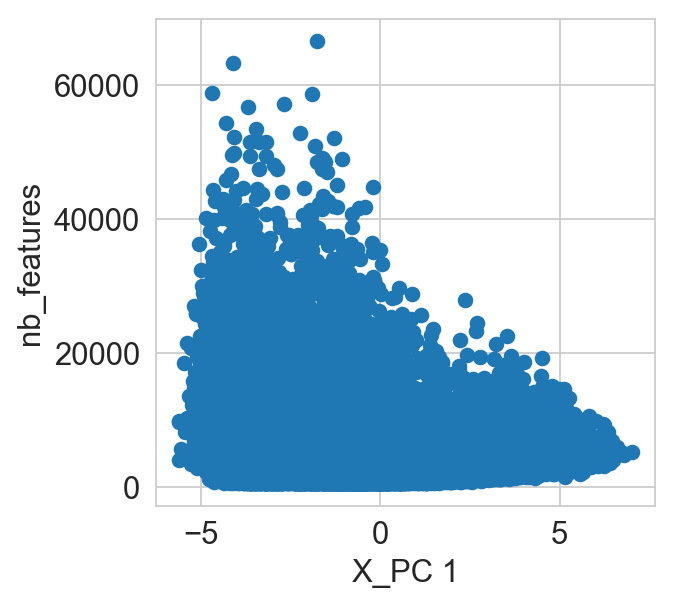

In [62]:
# check the correlation between library size and PC1 post normalisation
epi.pp.correlation_pc(adata, 'nb_features')

In [63]:
adata

AnnData object with n_obs × n_vars = 17503 × 75067 
    obs: 'batch', 'cell_names', 'tissue', 'sample', 'cell', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'nb_features'
    var: 'ensembl_id', 'gene_short_name', 'ensembl_transcript_id', 'biotype', 'strand', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'pca', 'tissue_colors', 'cell_label_colors', 'correlation_pc'
    obsm: 'X_pca'
    varm: 'PCs'

# Neighboring graph, tSNE and UMAP

In [66]:
epi.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
epi.tl.tsne(adata)
epi.tl.umap(adata)

In [67]:
adata

AnnData object with n_obs × n_vars = 17503 × 75067 
    obs: 'batch', 'cell_names', 'tissue', 'sample', 'cell', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'nb_features'
    var: 'ensembl_id', 'gene_short_name', 'ensembl_transcript_id', 'biotype', 'strand', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'pca', 'tissue_colors', 'cell_label_colors', 'correlation_pc', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

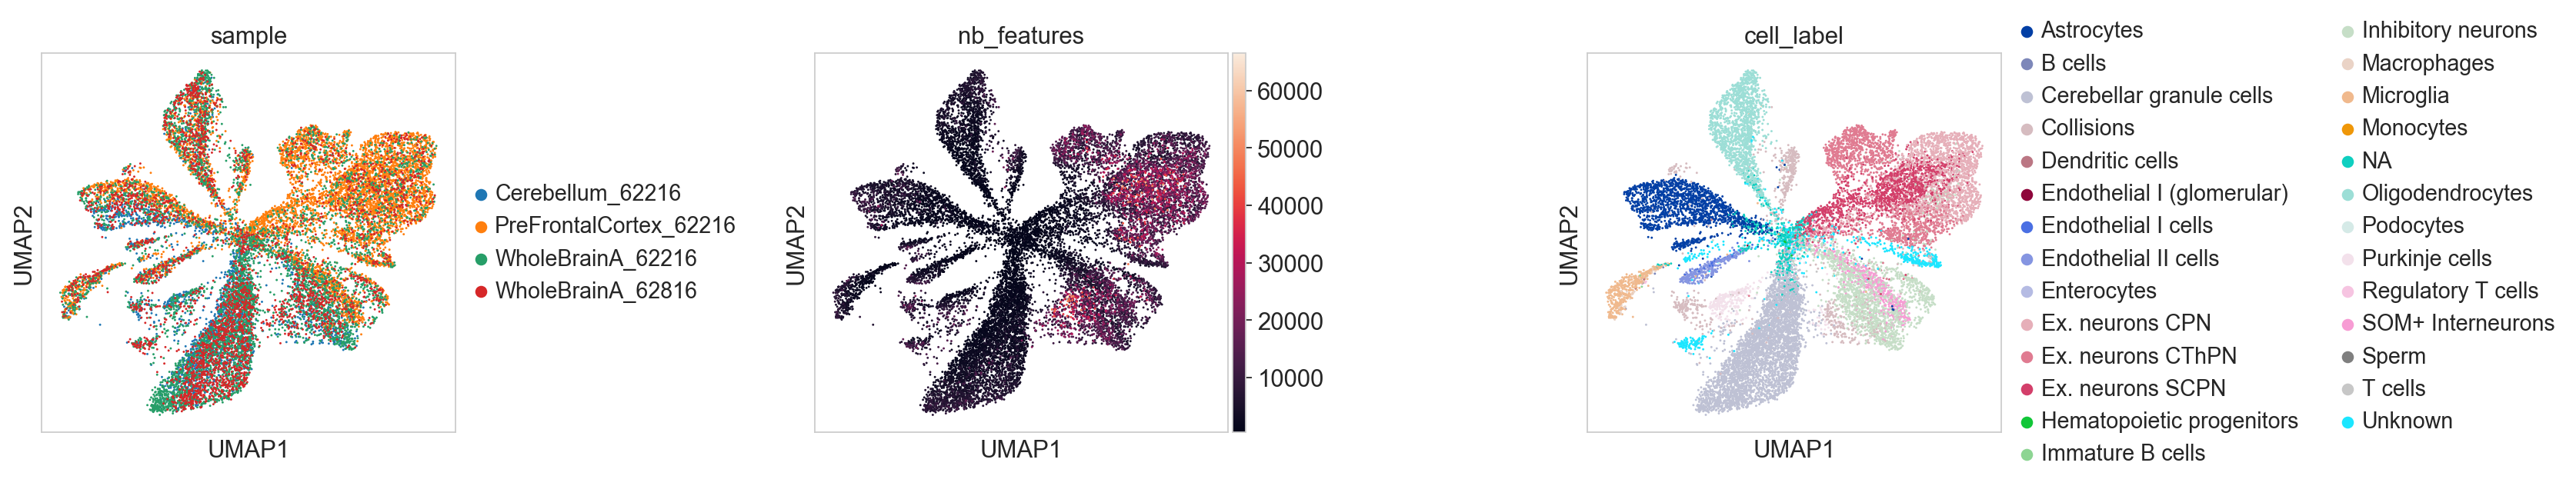

In [72]:
sc.pl.umap(adata, color=['sample', 'nb_features','cell_label'], wspace=0.7)

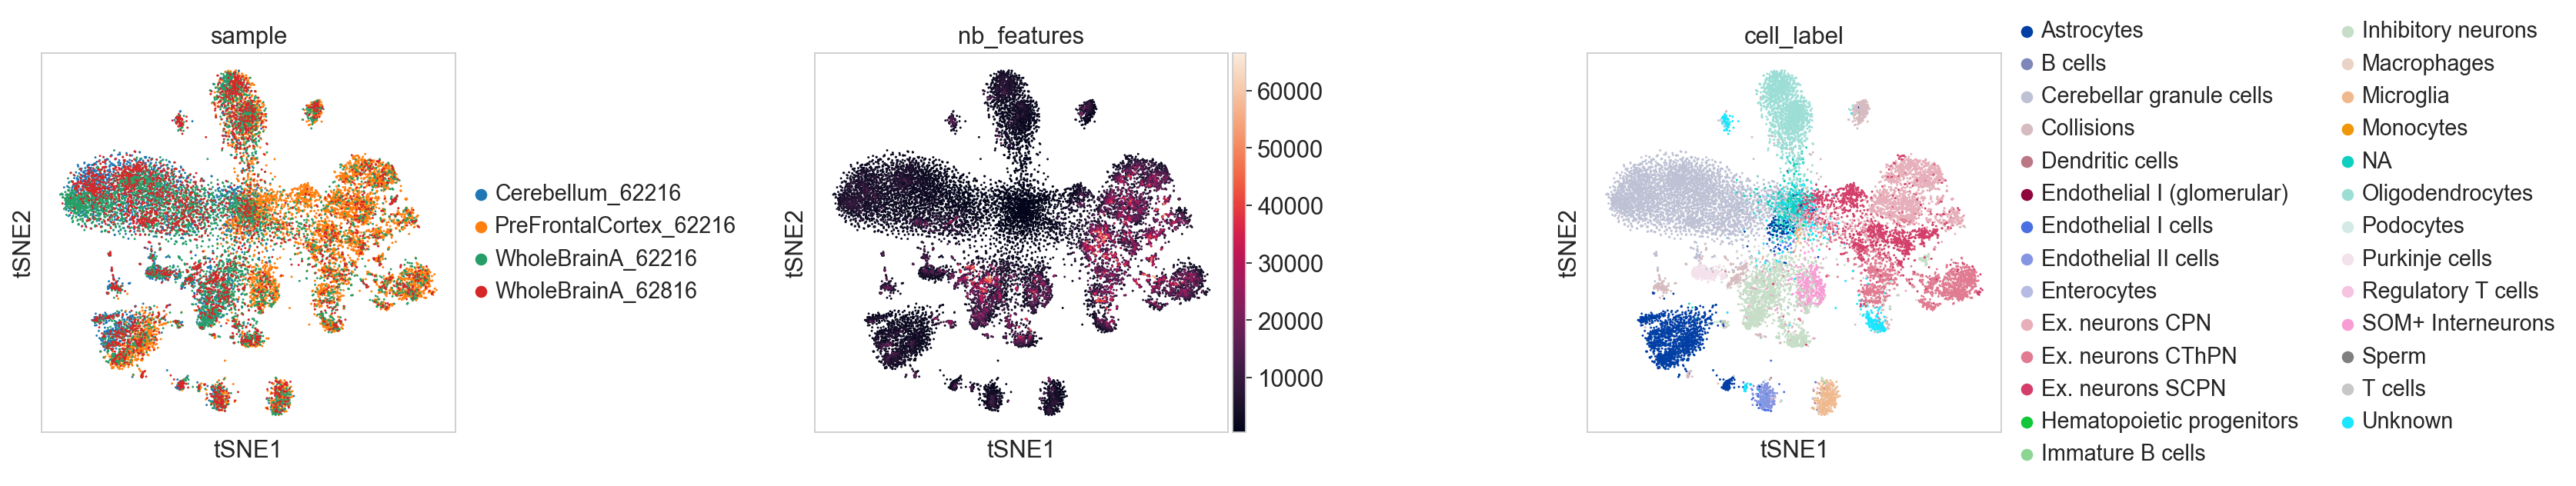

In [74]:
sc.pl.tsne(adata, color=['sample', 'nb_features','cell_label'], wspace=0.7)

### Louvain clustering

In [69]:
epi.tl.louvain(adata)

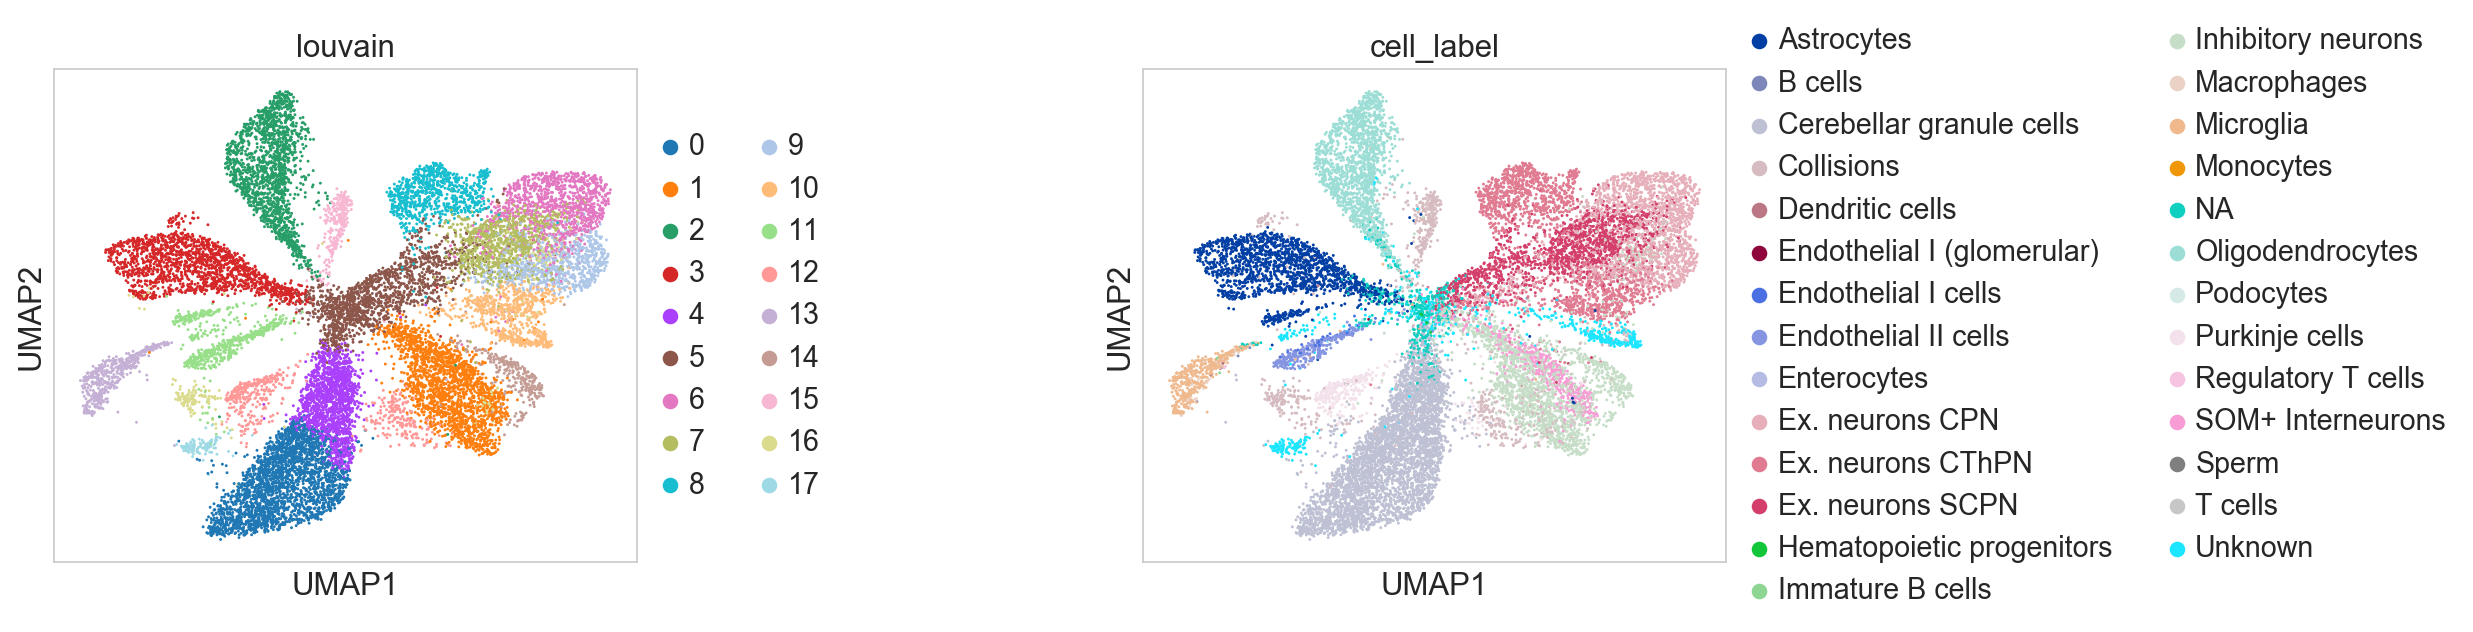

In [71]:
sc.pl.umap(adata, color=['louvain', 'cell_label'], wspace=0.7)

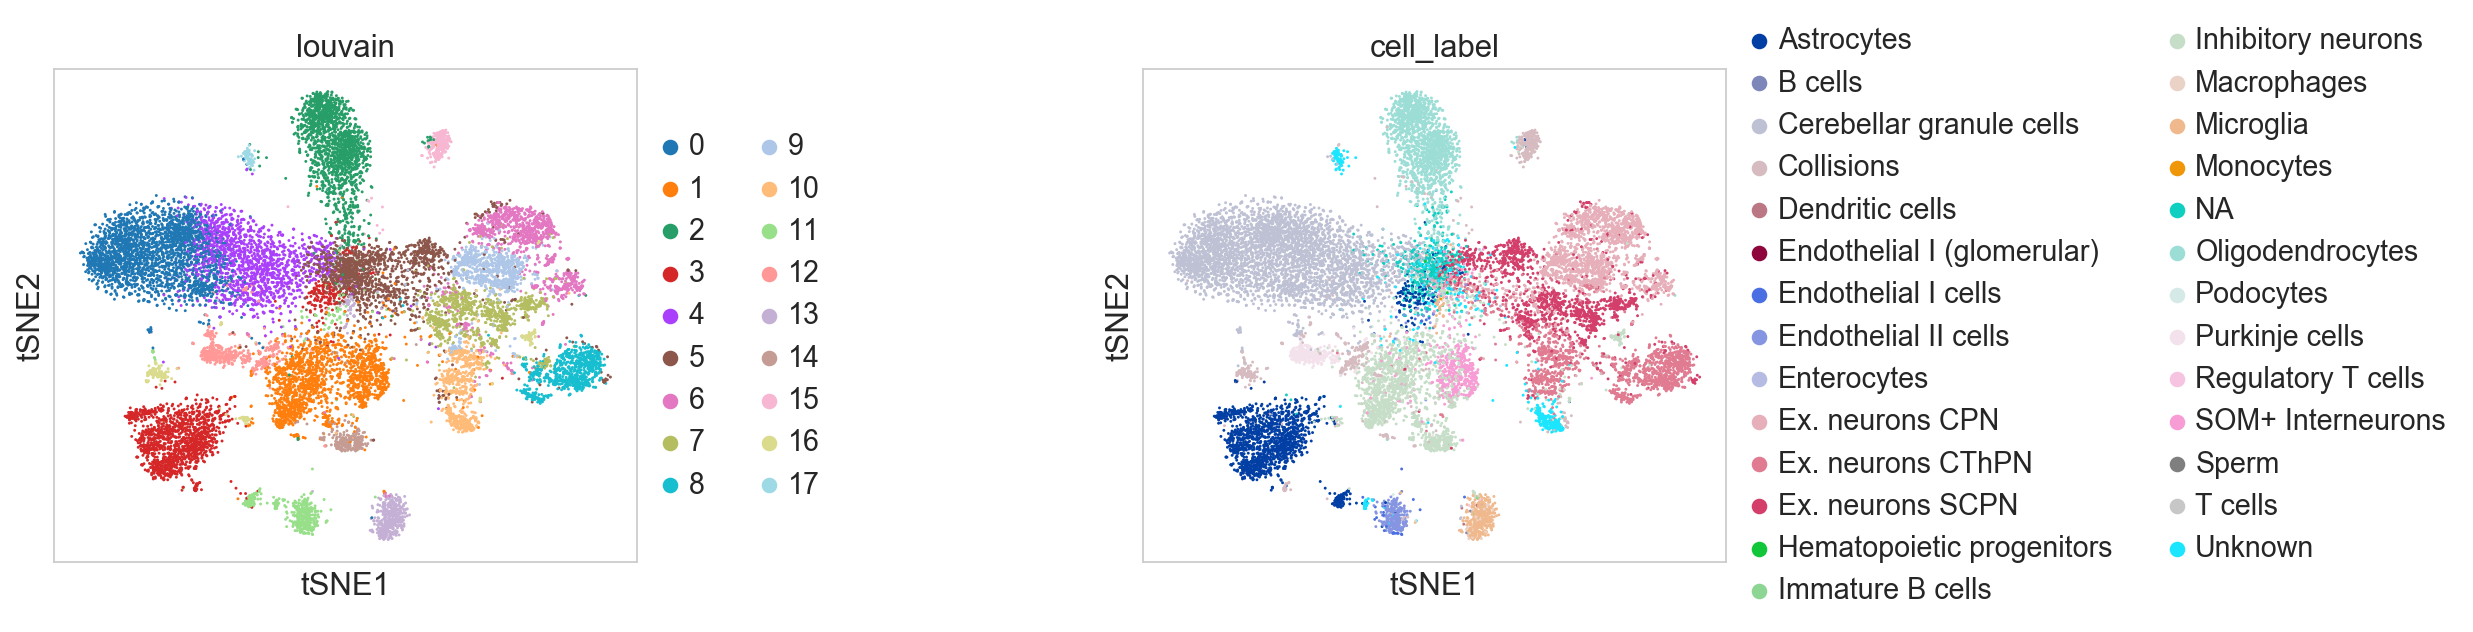

In [73]:
sc.pl.tsne(adata, color=['louvain', 'cell_label'], wspace=0.7)

### Last check before saveing

In [80]:
adata

AnnData object with n_obs × n_vars = 17503 × 75067 
    obs: 'batch', 'cell_names', 'tissue', 'sample', 'cell', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'nb_features', 'louvain'
    var: 'ensembl_id', 'gene_short_name', 'ensembl_transcript_id', 'biotype', 'strand', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'pca', 'tissue_colors', 'cell_label_colors', 'correlation_pc', 'neighbors', 'sample_colors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [110]:

for key in ['ensembl_id', 'gene_short_name', 'ensembl_transcript_id', 'biotype', 'strand']:
    annot = []
    for n in adata.var[key].tolist():
        if (n != 'NA') and ('\n' in n):
            line = n.split('\n')[1:-1]
            line = list(set([m.split(' ')[-1] for m in line]))
            annot.append(line)
        elif (n != 'NA'):
            annot.append([n])
        else:
            annot.append(n)
    #print(len(adata.var[key].tolist()), len(annot))
    adata.var[key] = annot

In [111]:
adata.var

ensembl_id  \
index                                                                        
chr1_3084739_3085712                                                    NA   
chr1_3109571_3111047                                                    NA   
chr1_3111379_3111807                                                    NA   
chr1_3282510_3283568                                                    NA   
chr1_3289336_3290295                                                    NA   
chr1_3299459_3300928                                                    NA   
chr1_3312010_3312977                                                    NA   
chr1_3359432_3360060                                                    NA   
chr1_3381847_3382720                                                    NA   
chr1_3389081_3391082                                                    NA   
chr1_3423492_3424607                                                    NA   
chr1_3456171_3457239                            [[[ENSMUSG00000089699.1]]]   
chr1_3504633_3505709                                                    NA   
chr1_3660494_3662750                            [[[ENSMUSG00000051951.5]]]   
chr1_3890233_3890892                                                    NA   
chr1_4079313_4080326                                                    NA   
chr1_4322219_4322930                                                    NA   
chr1_4404024_4405256                                                    NA   
chr1_4481787_4483554                                                    NA   
chr1_4486198_4487697                            [[[ENSMUSG00000025902.7]]]   
chr1_4561274_4562504                                                    NA   
chr1_4693102_4694216                                                    NA   
chr1_4758342_4759726                                                    NA   
chr1_4759875_4760620                                                    NA   
chr1_4775078_4776432                            [[[ENSMUSG00000033845.7]]]   
chr1_4797350_4799334                            [[[ENSMUSG00000025903.8]]]   
chr1_4847147_4848972                            [[[ENSMUSG00000033813.8]]]   
chr1_4863284_4864489                                                    NA   
chr1_4897661_4898891                                                    NA   
chr1_4916081_4917409                            [[[ENSMUSG00000091305.1]]]   
...                                                                    ...   
chrX_163246624_163247740                                                NA   
chrX_163390357_163391406                                                NA   
chrX_163584222_163585758                                                NA   
chrX_163645672_163646239                                                NA   
chrX_163646306_163647806                       [[[ENSMUSG00000049775.10]]]   
chrX_163670834_163671920                                                NA   
chrX_163714382_163715479                                                NA   
chrX_163766343_163769223                        [[[ENSMUSG00000044583.7]]]   
chrX_163819384_163821119                        [[[ENSMUSG00000025742.5]]]   
chrX_163935711_163936426                                                NA   
chrX_164089556_164090831                                                NA   
chrX_164266278_164267170                                                NA   
chrX_164292647_164293646                        [[[ENSMUSG00000049176.7]]]   
chrX_164559327_164562416                        [[[ENSMUSG00000049176.7]]]   
chrX_164788006_164789088                                                NA   
chrX_164867174_164868387                                                NA   
chrX_165006463_165007888                                                NA   
chrX_165077102_165078269                                                NA   
chrX_165110304_165113018                       [[[ENSMUSG00000031358.10]]]   
chrX_165

In [112]:
adata.obs

batch  \
index                                                      
AGCGATAGAACGCGCAGAGATGCAGTTCGGCTCTGA_Cerebellum...     0   
AGCGATAGAACGCGCAGATCAATATCGATATAGCCT_Cerebellum...     0   
AGCGATAGAATATTACTTCAATGAGTCCGGCTCTGA_Cerebellum...     0   
AGCGATAGAATATTACTTCCATCGTTCCTATAGCCT_Cerebellum...     0   
AGCGATAGAGAGGAGAATCCATCGTTCCATAGAGGC_Cerebellum...     0   
AGCGATAGAGAGGAGAATGGTACGTTAACCTATCCT_Cerebellum...     0   
AGCGATAGAGTTGAATCATTATGACCAATATAGCCT_Cerebellum...     0   
AGCGATAGATAAGGACTCGATGCAGTTCCCTATCCT_Cerebellum...     0   
AGCGATAGATAAGGACTCGGTACGTTAAGGCTCTGA_Cerebellum...     0   
AGCGATAGATAAGGACTCGGTACGTTAATATAGCCT_Cerebellum...     0   
AGCGATAGATAAGGACTCGTAGACCTGGGGCTCTGA_Cerebellum...     0   
AGCGATAGATAAGGACTCTTGGTCCGTTGGCTCTGA_Cerebellum...     0   
AGCGATAGATGGAACGAACAATGAGTCCGGCTCTGA_Cerebellum...     0   
AGCGATAGATGGAACGAAGATGCAGTTCGGCTCTGA_Cerebellum...     0   
AGCGATAGATGGAACGAAGGTACGTTAAGGCTCTGA_Cerebellum...     0   
AGCGATAGATGGAACGAATCAATATCGAGGCTCTGA_Cerebellum...     0   
AGCGATAGATGGCGCCTGCCATCGTTCCCCTATCCT_Cerebellum...     0   
AGCGATAGATGGCGCCTGGGTACGTTAATATAGCCT_Cerebellum...     0   
AGCGATAGATGGCGCCTGGTAGACCTGGTATAGCCT_Cerebellum...     0   
AGCGATAGATTATGCAAGCCATCGTTCCGGCTCTGA_Cerebellum...     0   
AGCGATAGATTATGCAAGGATGCAGTTCATAGAGGC_Cerebellum...     0   
AGCGATAGATTCTTAGCTGTAGACCTGGTATAGCCT_Cerebellum...     0   
AGCGATAGATTCTTAGCTTCAATATCGAATAGAGGC_Cerebellum...     0   
AGCGATAGATTGGCAGATCCATCGTTCCTATAGCCT_Cerebellum...     0   
AGCGATAGATTGGCAGATGGTACGTTAATATAGCCT_Cerebellum...     0   
AGCGATAGCATAGCGACCCAATGAGTCCATAGAGGC_Cerebellum...     0   
AGCGATAGCATAGCGACCCCATCGTTCCGGCTCTGA_Cerebellum...     0   
AGCGATAGCATAGCGACCTCAATATCGACCTATCCT_Cerebellum...     0   
AGCGATAGCCGCTAAGAGGTAGACCTGGGGCTCTGA_Cerebellum...     0   
AGCGATAGCCGCTAAGAGTTATGACCAATATAGCCT_Cerebellum...     0   
...                                                  ...   
TCTCGCGCTGGACGACTATGCCAGTTGCAGGCGAAG_WholeBrain...     0   
TCTCGCGCTGGTTGCCGTATTGACCGAGAGGCGAAG_WholeBrain...     0   
TCTCGCGCTGGTTGCCGTATTGACCGAGGTACTGAC_WholeBrain...     0   
TCTCGCGCTGGTTGCCGTCGCCTCTTATAGGCGAAG_WholeBrain...     0   
TCTCGCGCTGGTTGCCGTGAGACCTACCGTACTGAC_WholeBrain...     0   
TCTCGCGCTGGTTGCCGTGAGACCTACCTATAGCCT_WholeBrain...     0   
TCTCGCGCTGGTTGCCGTGCGATTGCAGAGGCGAAG_WholeBrain...     0   
TCTCGCGCTGGTTGCCGTGCGATTGCAGGTACTGAC_WholeBrain...     0   
TCTCGCGCTGGTTGCCGTGTCTGCAATCAGGCGAAG_WholeBrain...     0   
TCTCGCGCTGGTTGCCGTGTCTGCAATCTATAGCCT_WholeBrain...     0   
TCTCGCGCTGGTTGCCGTGTTGGATCTTTATAGCCT_WholeBrain...     0   
TCTCGCGCTGGTTGCCGTTGCCAGTTGCAGGCGAAG_WholeBrain...     0   
TCTCGCGCTTCGAATATTATTGACCGAGGGCTCTGA_WholeBrain...     0   
TCTCGCGCTTCGAATATTCGCCTCTTATAGGCGAAG_WholeBrain...     0   
TCTCGCGCTTCGAATATTCTTAGGTATCGGCTCTGA_WholeBrain...     0   
TCTCGCGCTTCGAATATTGAGACCTACCCAGGACGT_WholeBrain...     0   
TCTCGCGCTTCGAATATTGAGACCTACCTATAGCCT_WholeBrain...     0   
TCTCGCGCTTCGAATATTGCGATTGCAGAGGCGAAG_WholeBrain...     0   
TCTCGCGCTTCGAATATTGTCTGCAATCAGGCGAAG_WholeBrain...     0   
TCTCGCGCTTCGAATATTGTCTGCAATCGTACTGAC_WholeBrain...     0   
TCTCGCGCTTCGAATATTGTTGGATCTTGTACTGAC_WholeBrain...     0   
TCTCGCGCTTCGAATATTTGCCAGTTGCAGGCGAAG_WholeBrain...     0   
TCTCGCGCTTCGAATATTTGCCAGTTGCCCTATCCT_WholeBrain...     0   
TCTCGCGCTTCGAATATTTGCCAGTTGCGGCTCTGA_WholeBrain...     0   
TCTCGCGCTTGCTTAGATGAGACCTACCAGGCGAAG_WholeBrain...     0   
TCTCGCGCTTGCTTAGATGAGACCTACCTATAGCCT_WholeBrain...     0   
TCTCGCGCTTGCTTAGATGTCTGCAATCCCTATCCT_WholeBrain...     0   
TCTCGCGCTTGCTTAGATGTCTGCAATCTATAGCCT_WholeBrain...     0   
TCTCGCGCTTGCTTAGATGTTGGATCTTAGGCGAAG_WholeBrain...     0   
TCTCGCGCTTGCTTAGATGTTGGATCTTGTACTGAC_WholeBrain...     0   

                                                                                           cell_names  \
index                                                                                                   
AGCGATAGAACGCGCAGAGATGCAGTTCGGCTCTGA_Cerebellum...  AGCGATAG

In [113]:
adata.write(DATADIR+result_file)

... storing 'ensembl_id' as categorical
... storing 'gene_short_name' as categorical
... storing 'ensembl_transcript_id' as categorical
... storing 'biotype' as categorical
... storing 'strand' as categorical
